In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [6]:
# vamos importar a série histórica da petrobras
df = pd.read_excel('petr4.xlsx', parse_dates=['date'])
df.tail()

,date,close
5672,2022-07-29,34.150002
5673,2022-08-01,33.680000
5674,2022-08-02,33.830002
5675,2022-08-03,33.849998
5676,2022-08-04,34.020000


In [7]:
df.set_index('date', inplace=True)

In [8]:
df

,close
date,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-07-29,34.150002
2022-08-01,33.680000
2022-08-02,33.830002


In [9]:
# Quando começam e terminam os dados?
df.index.min(), df.index.max()

(Timestamp('2000-01-03 00:00:00'), Timestamp('2022-08-04 00:00:00'))

In [10]:
df.columns = ['preco']

<AxesSubplot:xlabel='date'>

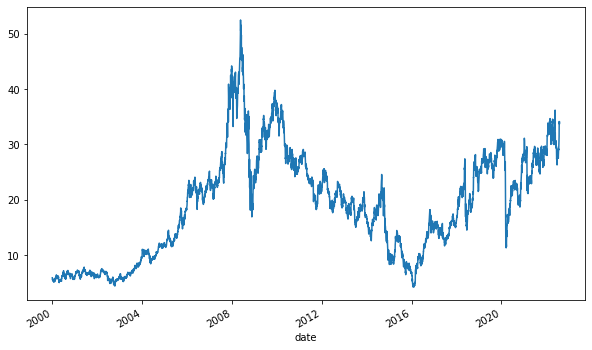

In [11]:
# Vamos dar uma olhada no gráfico de preco x anos
df['preco'].plot(figsize=(10,6))

### Prevendo com ARIMA

notebook referencia:

https://www.kaggle.com/ludovicocuoghi/electric-production-forecast-lstm-sarima

In [12]:
df.isna().sum()

preco    0
dtype: int64

<Figure size 1152x864 with 0 Axes>

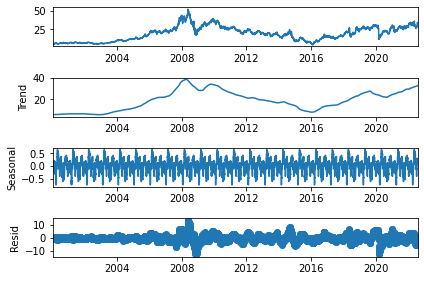

In [14]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df, model='additive', period=252, extrapolate_trend = 'freq')

fig = plt.figure(figsize=(16, 12))  
fig = resultado.plot()

#### Teste de estacionariedade

In [16]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['preco'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.206588857368607
p-valor:0.20386277898879257


/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


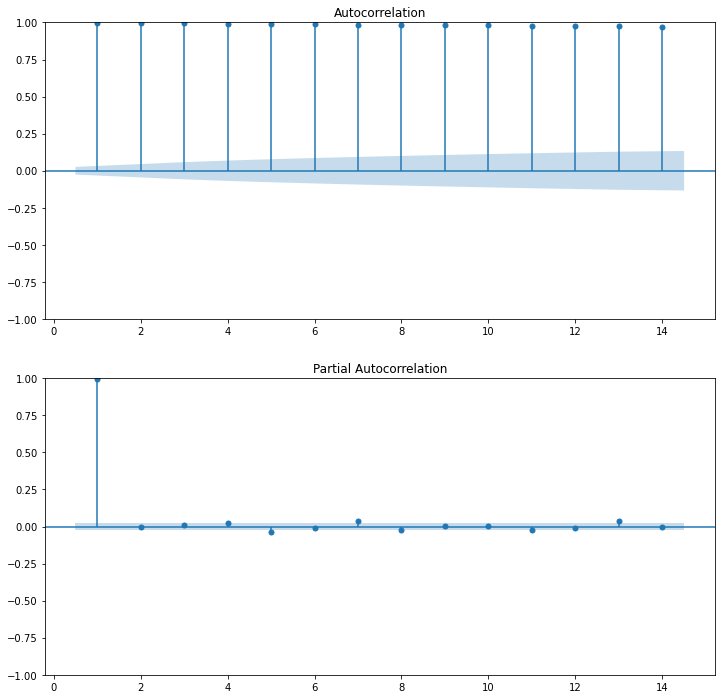

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(12,12))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

#### Ou seja, a série não é realmente estacionária (p-valor >0.05, não podemos rejeitar a hipótese nula)

In [18]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=11.99 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=13242.697, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=11650.099, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=4.94 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=13240.771, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=10965.515, Time=1.44 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=11.24 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=6.80 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=10963.771, Time=0.87 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=11649.148, Time=0.49 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=8.49 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=5.16 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=10965.506, Time=1.37 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=11.69 sec
 ARIMA(0,1,0)(2,1,0)[6] intercept   : AIC=10965.761, Time=

In [19]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(0,1,0),  seasonal_order=(2,1,0,6))
resultado_sarimax = model.fit()

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65104D-01    |proj g|=  3.25782D-03

At iterate    5    f=  9.65102D-01    |proj g|=  3.99863D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.999D-06   9.651D-01
  F =  0.96510226620470729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [20]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             preco   No. Observations:                 5677
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -5478.886
Date:                           Sat, 06 Aug 2022   AIC                          10963.771
Time:                                   08:57:38   BIC                          10983.700
Sample:                                        0   HQIC                         10970.712
                                          - 5677                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.6631      0.007    -98.589      0.000      -0.676      -0.650
ar.S.L12      -0.3380      0.006    -53.425      0.000      -0.350      -0.326
sigma2         0.4042      0.003    136.150      0.000       0.398       0.410
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):             32046.53
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               6.75   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-252)
predicao_media = predicoes.predicted_mean

In [22]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(25.40823461996463, 27.900374785135938)

In [28]:
predicao_media[0]

26.654304702550284

In [29]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

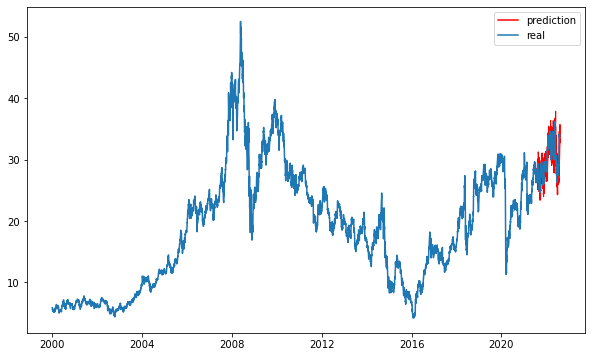

In [30]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-252:].values,predicao_media.values))
print(rmse_sarima)

0.915136539207053


#### FORECAST COM ARIMA

In [32]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=252)
forecast_medio = forecast.predicted_mean
forecast_medio.size

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


252

In [34]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[5925], intervalo_acima_f[5925]

(-122.92221238901075, 368.03020556595004)

In [35]:
intervalo_confianca_forecast

,lower preco,upper preco
5677,32.941973,35.434114
5678,33.010378,36.534797
5679,32.299898,36.616411
5680,32.620830,37.605110
5681,32.650531,38.223126
...,...,...
5924,-121.219636,366.848650
5925,-122.922212,368.030206
5926,-123.747521,370.072184
5927,-124.952064,371.718376


In [36]:
forecast_medio[5925]

122.55399658846963

In [37]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

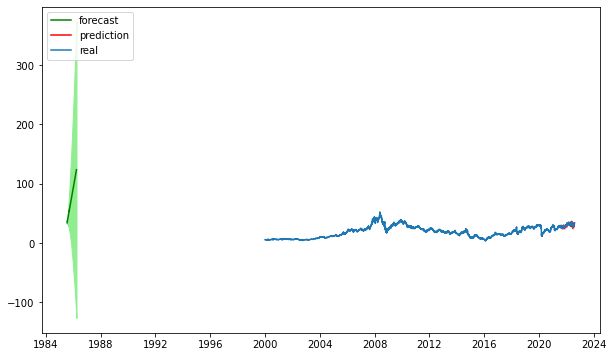

In [38]:
dates=np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()